In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [17]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0.6, max=0.9)
    return x


In [18]:
N_Agents = 1
in_dim = 1
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 4
control_energy_reg = 0#1e-6 ### regularization on maximum control energy
u_max = 100 # does not do anything currently
thres = 0#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [19]:
densties = ['custom']
regions = [
        torch.tensor([[.0, .3]]),
        torch.tensor([[.6, .9]])
        ]
weights = [.5, .5]

In [20]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    #return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    return np.where((x > 0.6) & (x < 0.9),3, 0)

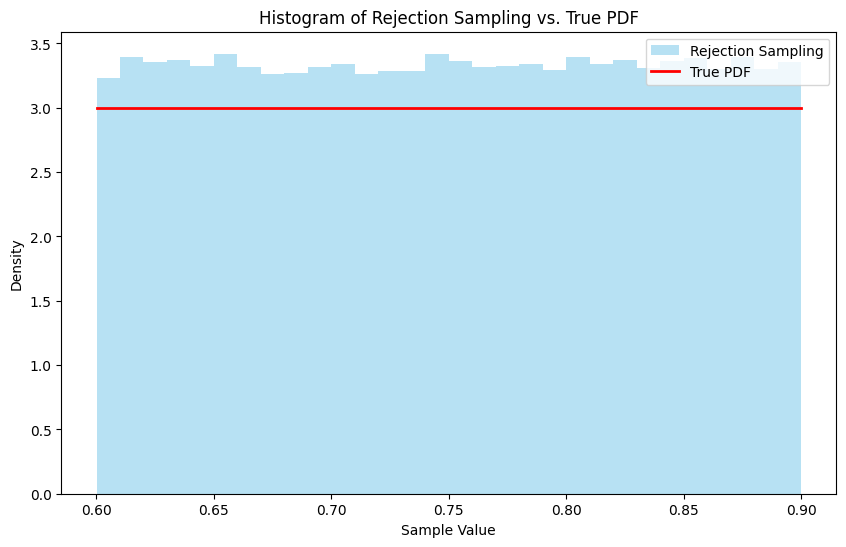

tensor([ 1.0000, -0.9641,  0.0019,  0.6964]) target distribution


In [21]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 5/3, num_samples = 100000)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 128, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)

In [22]:
optimizer_lbfgs = optim.LBFGS(model.parameters(), line_search_fn = 'strong_wolfe')


per iter: 12.019503355026245 total time: 4807.801342010498
Epoch [1/50], Loss: 2.954899
Epoch [2/50], Loss: 2.861449
Epoch [3/50], Loss: 2.860691
Epoch [4/50], Loss: 2.862037
Epoch [5/50], Loss: 2.879414
Epoch [6/50], Loss: 2.882509
Epoch [7/50], Loss: 2.882602
Epoch [8/50], Loss: 2.882229
Epoch [9/50], Loss: 2.891829
Epoch [10/50], Loss: 2.891777
Epoch [11/50], Loss: 2.890357
Epoch [12/50], Loss: 2.890187
Epoch [13/50], Loss: 2.890330
Epoch [14/50], Loss: 2.890569
Epoch [15/50], Loss: 2.890760
Epoch [16/50], Loss: 2.892214
Epoch [17/50], Loss: 2.890181
Epoch [18/50], Loss: 2.891439
Epoch [19/50], Loss: 2.891202
Epoch [20/50], Loss: 2.890414
Epoch [21/50], Loss: 2.889013
Epoch [22/50], Loss: 2.889997
Epoch [23/50], Loss: 2.890758
Epoch [24/50], Loss: 2.890236
Epoch [25/50], Loss: 2.890148
Epoch [26/50], Loss: 2.886808
Epoch [27/50], Loss: 2.879388
Epoch [28/50], Loss: 2.873232
Epoch [29/50], Loss: 2.876126
Epoch [30/50], Loss: 2.874665
Epoch [31/50], Loss: 2.875036
Epoch [32/50], Loss:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [50/50], Loss: 2.872980


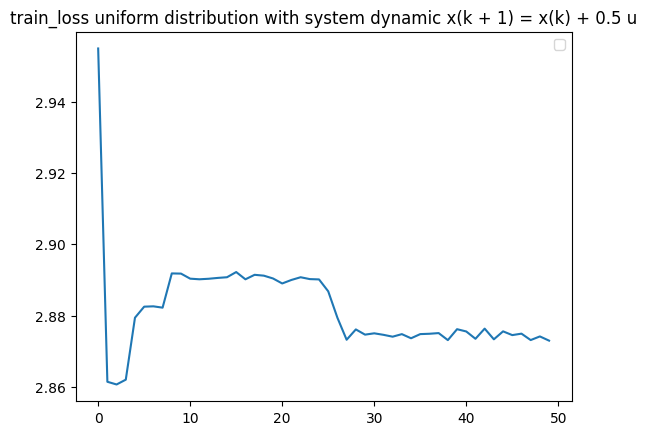

Training Complete!


In [23]:
import time
criterion.verbose = False
epochs = 50  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        inputs = gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim)
        def closure():
            model.init_hidden(batch_size = batch_size)
            optimizer_lbfgs.zero_grad()
            outputs, control = model(inputs)
            loss = criterion(x = outputs, u = control) + model.penalty
            loss.backward()
            return loss
        optimizer_lbfgs.step(closure)
        with torch.no_grad():
            model.init_hidden(batch_size = batch_size)
            control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
            loss = criterion(x = outputs, u = control) + model.penalty
        running_loss += loss.item()
        if show:
            show = False
            criterion.verbose = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)
    
    avg_loss = running_loss / (n_samples // batch_size)
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


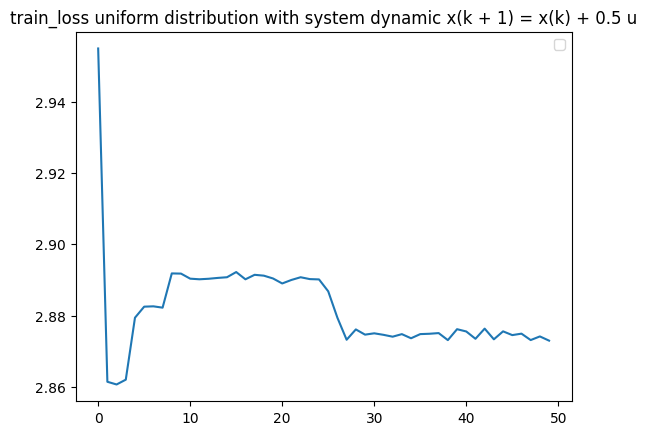

Training Complete!


In [24]:
plt.plot(train_loss[-300:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

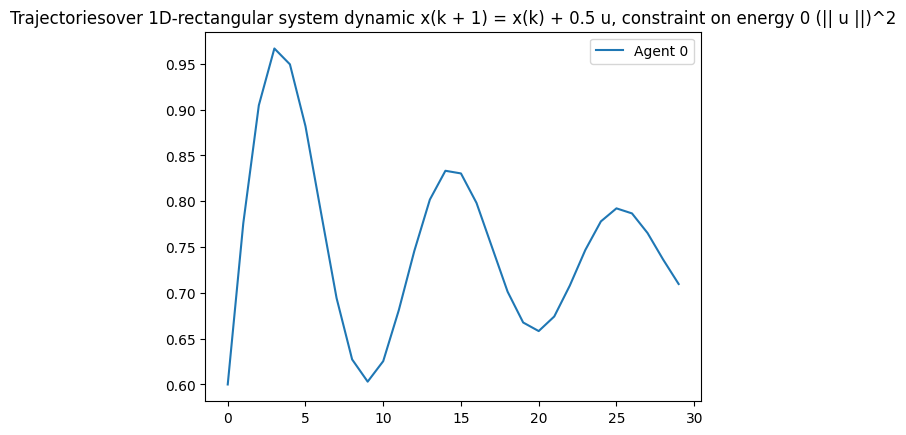

In [25]:
#plot trajectory
#model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()



In [26]:
#import Ergodic_Loss
#import sys
#sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
#import importlib
#importlib.reload(Ergodic_Loss)
#criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max,control_energy_reg = control_energy_reg, density = 'custom', pdf = custom_pdf, max_pdf = 5 / 3, num_samples = 100000)
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion.verbose = True
criterion(x = outs, u = control)

model: tensor(-0.9636, grad_fn=<SelectBackward0>) target: tensor(-0.9641)


tensor(0.0006, grad_fn=<AddBackward0>)

In [27]:
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion(x = outs, u = control)

model: tensor(-0.9766, grad_fn=<SelectBackward0>) target: tensor(-0.9641)


tensor(0.0081, grad_fn=<AddBackward0>)